In [106]:
using Revise
using Pkg; Pkg.activate(".")

using Dates
using Statistics
using Interpolations
using DSP
using NCDatasets
using JLD2

include("./read_lidar.jl")
using .read_lidar
# using MAT

using PyPlot

  Activating project at `~/Projects/ASTRAL/lidar`


In [3]:
# utility functions
pd = permutedims
m2n(x) = ismissing(x) ? NaN : x

"bin average y in bins b of coordinate x"
function binavg(y, x, b)
    a = zeros(length(b))
    c = zeros(length(b))
    for (i,x) in enumerate(x)
        bi = findlast(j -> j < x, b)
        a[bi] += y[i]
        c[bi] += 1
    end
    return a./c
end


binavg

In [4]:
#= test stuff out
nt = 1000
nc = 3

# construct the indices of the combination sets
ci = CartesianIndices((nt,nc))
li = LinearIndices(ci)

# Generate the set of unique pairs of indices (l1,l2)
# where l1 < l2.
# Set() makes unique but it's slow and the result of the comprehension is already unique. 
lpairs = [ (l1, l2) for l1 in li[:] for l2 in (l1+1):last(li) ]
l1 = first.(lpairs) # vector of linear indices to points 1 of pairs
l2 =  last.(lpairs) #                             points 2
# str_fcn = w[ci[l1]] - w[ci[l2]])

# w can be indexed directly with ci[first.(lpairs])
# unpack the CartesianIndex to subscript the time[it], range[iz]
# idx[1] works but first(idx) tries to iterate which is unsupported
it1 = map(idx->idx[1], ci[l1]) #  t index of first point(s)
iz1 = map(idx->idx[2], ci[l1]) #  z index of first
it2 = map(idx->idx[1], ci[l2]) #  t       of second points(s)
iz2 = map(idx->idx[2], ci[l2]) #  z          second
#     first.(Tuple.(ci[l1])) # this also works

=#

In [5]:
# functions for structure functions

# generate unique pairs of indices
"index unique pairs in a vector of length n"
function uniquepairs(n) 
    [ [l1, l2] for l1 in 1:n for l2 in (l1+1):n ]
end
"index pairs of points in adjacent levels"
allcross(n) = [ [l1, l2] for l1 in 1:n for l2 in 1:n ]

# beam geometry
"lidar beam range"
rng(iz, rangegate=24.0) = rangegate * (iz-1 + 0.5)

rng

In [83]:
"""
compile indices of lidar volumes to be compared with
structure functions
"""
function lidarindices(nt, nz, z1=1; nlevelstats=1)
    if nlevelstats == 3
        # The complete set that doesn't repeat pairs is 
        # 1 the complete set of nt*(n-1)/2 pairs for the top level (3)
        # 2 the 2*nt*nt sets of pairs between every point in top (3) level and the next 2 levels
        # Iteratively slide this box upward by 1 level for each level.
    
        # index pairs in middle level 2-2
        up = uniquepairs(nt)
        it1 = map(i->i[1], up) # time indices for pairs of point1, point2
        it2 = map(i->i[2], up)
        ci1_r22 = CartesianIndex.(tuple.(it1,z1)) # 1st point in pair lev
        ci2_r22 = CartesianIndex.(tuple.(it2,z1)) # 2nd 
    
        # index pairs of points from level 2-1, and 2-3
        ac = allcross(nt)
        it1 = map(i->i[1], ac)
        it2 = map(i->i[2], ac)
        ci1_r21 = ci1_r23 = CartesianIndex.(tuple.(it1,2))
        ci2_r21 = CartesianIndex.(tuple.(it2,z1-1))
        ci2_r23 = CartesianIndex.(tuple.(it2,z1+1))
    
        # omnibus set of cartesian index pairs for a level, including points in lev above and below
        ci1 = [ci1_r23; ci1_r22; ci1_r21] # first of pairs
        ci2 = [ci2_r23; ci2_r22; ci2_r21]
        li1 = LinearIndices(ci1)
        li2 = LinearIndices(ci2)
        
    elseif nlevelstats == 1
        # just use structure function velocity pairs from one level of lidar range
        up = uniquepairs(nt)
        it1 = map(i->i[1], up) # time indices for pairs of point1, point2
        it2 = map(i->i[2], up)
        ci1_r11 = CartesianIndex.(tuple.(it1,z1)) # 1st point in pair lev
        ci2_r11 = CartesianIndex.(tuple.(it2,z1)) # 2nd point in same lev
    
        # set of cartesian index pairs for a level, including points in lev above and below
        ci1 = ci1_r11 # first of pairs
        ci2 = ci2_r11
        li1 = LinearIndices(ci1)
        li2 = LinearIndices(ci2)
    end
    
    it1 = map(idx->idx[1], ci1) #  t index of first point(s)
    iz1 = map(idx->idx[2], ci1) #  z index of first
    it2 = map(idx->idx[1], ci2) #  t       of second points(s)
    iz2 = map(idx->idx[2], ci2) #  z          second
    
    return ci1,ci2, li1,li2, it1,iz1,it2,iz2
end

# try example
ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(1000, 80)

#= moved to function
nlevelstats = 1

if nlevelstats == 3
    # The complete set that doesn't repeat pairs is 
    # 1 the complete set of nt*(n-1)/2 pairs for the top level (3)
    # 2 the 2*nt*nt sets of pairs between every point in top (3) level and the next 2 levels
    # Iteratively slide this box upward by 1 level for each level.

    # index pairs in middle level 2-2
    up = uniquepairs(nt)
    it1 = map(i->i[1], up) # time indices for pairs of point1, point2
    it2 = map(i->i[2], up)
    ci1_r22 = CartesianIndex.(tuple.(it1,2)) # 1st point in pair lev
    ci2_r22 = CartesianIndex.(tuple.(it2,2)) # 2nd 

    # index pairs of points from level 2-1, and 2-3
    ac = allcross(nt)
    it1 = map(i->i[1], ac)
    it2 = map(i->i[2], ac)
    ci1_r21 = ci1_r23 = CartesianIndex.(tuple.(it1,2))
    ci2_r21 = CartesianIndex.(tuple.(it2,1))
    ci2_r23 = CartesianIndex.(tuple.(it2,3))

    # omnibus set of cartesian index pairs for a level, including points in lev above and below
    ci1 = [ci1_r23; ci1_r22; ci1_r21] # first of pairs
    ci2 = [ci2_r23; ci2_r22; ci2_r21]
    li1 = LinearIndices(ci1)
    li2 = LinearIndices(ci2)
    
elseif nlevelstats == 1
    # just use structure function velocity pairs from one level of lidar range
    up = uniquepairs(nt)
    it1 = map(i->i[1], up) # time indices for pairs of point1, point2
    it2 = map(i->i[2], up)
    ci1_r11 = CartesianIndex.(tuple.(it1,1)) # 1st point in pair lev
    ci2_r11 = CartesianIndex.(tuple.(it2,1)) # 2nd 

    # set of cartesian index pairs for a level, including points in lev above and below
    ci1 = ci1_r11 # first of pairs
    ci2 = ci2_r11
    li1 = LinearIndices(ci1)
    li2 = LinearIndices(ci2)
end

it1 = map(idx->idx[1], ci1) #  t index of first point(s)
iz1 = map(idx->idx[2], ci1) #  z index of first
it2 = map(idx->idx[1], ci2) #  t       of second points(s)
iz2 = map(idx->idx[2], ci2) #  z          second
=#

(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1)  …  CartesianIndex(996, 1), CartesianIndex(996, 1), CartesianIndex(996, 1), CartesianIndex(996, 1), CartesianIndex(997, 1), CartesianIndex(997, 1), CartesianIndex(997, 1), CartesianIndex(998, 1), CartesianIndex(998, 1), CartesianIndex(999, 1)], CartesianIndex{2}[CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1), CartesianIndex(11, 1)  …  CartesianIndex(997, 1), CartesianIndex(998, 1), CartesianIndex(999, 1), CartesianIndex(1000, 1), CartesianIndex(998, 1), CartesianIndex(999, 1), CartesianIndex(1000, 1), CartesianIndex(999, 1), CartesianIndex(1000, 1), CartesianIndex(1000, 1)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 1

In [65]:
# Adjust true vertical velocity for relative wind * sin(tilt)
# and the platform velocity
trigs(pitch, roll) = ( cos(pitch), sin(pitch), cos(roll), sin(roll) )
# cospitch, sinpitch, cosroll, sinroll = trigs(pitch, roll)

function wtrue(w, Ur, Vr, pitch, roll)
    cospitch, sinpitch, cosroll, sinroll = trigs(pitch, roll)
    wtrue = ( w + Ur*sinpitch - Vr*cospitch*sinroll ) / (cospitch*cosroll)
end

# displacements with no adjustment for tilting into the horizontal wind 
# U, V vary slowly; pitch,roll,w vary fast
# there are nt*(nt-1)/2 ~ O(nt^2) outputs, so correct stuff first

rangegate = 24.0
"""
zm, dr2, dz2, D2 = displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate)
Displacements of sample pairs for one (vertical) subvolume.
"""
function displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate , timestep=timestep)
    # get the individual indices
    it1 = map(idx->idx[1], ci1) #  t index of first point(s)
    iz1 = map(idx->idx[2], ci1) #  z index of first
    it2 = map(idx->idx[1], ci2) #  t       of second points(s)
    iz2 = map(idx->idx[2], ci2) #  z          second

    rng(iz) = rangegate * (iz-1 + 0.5) # center of gates

    # horiz translation of the sample volumes by mean wind
    Udtbar = @. (Udt[iz2] + Udt[iz1]) / 2
    Vdtbar = @. (Vdt[iz2] + Vdt[iz1]) / 2
    X = @. Udtbar * (it2 - it1)
    Y = @. Vdtbar * (it2 - it1)
    # vertical middle of pair
    zm = @. (rng(iz2) * cos(pitch[it2])*cos(roll[it2]) + rng(iz1) * cos(pitch[it1])*cos(roll[it1])) / 2
    # displacement between pair of points
    dz = @.     rng(iz2) * cos(pitch[it2])*cos(roll[it2]) - rng(iz1) * cos(pitch[it1])*cos(roll[it1])
    dx = @. X + rng(iz2) *-sin(pitch[it2])                - rng(iz1) *-sin(pitch[it1])
    dy = @. Y + rng(iz2) * cos(pitch[it2])*sin(roll[it2]) - rng(iz1) * cos(pitch[it1])*sin(roll[it1])
    # distance between
    dz2 = dz .* dz
    dr2 = @. dz2 + dx*dx + dy*dy
    # CORRECT W for HEAVE and for TILTING into the horizontal wind
    # vel structure function
    D2 = @. (w[ci2] - w[ci1])^2
    # return properties of pairs
    return zm, dr2, dz2, D2
end

"dr^2/3 (1-(dz/dr)^2/4) displacement function for computing dissipation from structure function pairs"
rhopair(dr2, dz2) = dr2^(1/3) * (1 - dz2/(4*dr2))

rhopair

In [66]:
# make simple linear temporal interpolation
# maybe fast
# most time is spent searching for indices
# indices are monotonic

"find indices i such that each xl[i] is the first >= xs."
function findindices(xs, xl)
    ind = zeros(Int64, size(xs))
    i = 1
    for (j,x) in enumerate(xs)
        while xl[i] < x
            i += 1
        end
        ind[j] = i
    end
    return ind
end

"average within +-half points of the index of xl"
function indavg(xl, ind; half=5)
    xm = zeros(Float64, size(ind))
    for (i,idx) in enumerate(ind)
        ii = max(1,idx-half) : min(length(xl),idx+half)
        xm[i] = sum(Float64.(xl[ii])) / (2*half+1)
    end
    return xm
end

# test data
xl = 1:60_000_000
xs = 20:20:60_000_000

ind = findindices(xs, xl)
indavg(xl, ind)

3000000-element Vector{Float64}:
  20.0
  40.0
  60.0
  80.0
 100.0
 120.0
 140.0
 160.0
 180.0
 200.0
 220.0
 240.0
 260.0
   ⋮
   5.999978e7
   5.99998e7
   5.999982e7
   5.999984e7
   5.999986e7
   5.999988e7
   5.99999e7
   5.999992e7
   5.999994e7
   5.999996e7
   5.999998e7
   3.2727271363636363e7

In [67]:
#example time
dt = DateTime(2024,5,9,12,0,0)

# for interpolating from datetimes
timeinterp(dt, x) = interpolate((Dates.value.(dt),), x, Gridded(Linear()))

# load data sets

# load vectornav
Vn = read_daily_Vn( dt )            # Dict
# pitch, roll, heave interpolators
# keys(Vn)
itp_pitch(dt) = timeinterp( Vn["time"], Vn["pitch"] )[Dates.value.(dt)]
itp_roll(dt)  = timeinterp( Vn["time"], Vn["roll"]  )[Dates.value.(dt)]
itp_heave(dt) = timeinterp( Vn["time"], Vn["heave"] )[Dates.value.(dt)]

# load mean relative horizontal winds
UV = get_daily_meanuv( dt )         # NCDataset
# relative wind computed by Jayesh Phadtare
# U = UV[:ur][:,:] # 144 time (10 min), 150 height
# V = UV[:vr][:,:] # utrue = UV[:ut][:,:] # 144t, 150z
# use relative wind from Jayesh Phadtare to define interpolators
#=
itp_Ur(dt,z) = interpolate( (Dates.value.(UV[:time][:]), UV[:z_range][:]),
                              UV[:ur][:,:], Gridded(Linear()))(Dates.value(dt), z )
itp_Vr(dt,z) = interpolate( (Dates.value.(UV[:time][:]), UV[:z_range][:]),
                              UV[:vr][:,:], Gridded(Linear()))(Dates.value(dt), z )
=#
itp_Ur(dt,z) = interpolate( (Dates.value.(UV[:time][:]), axes(UV[:z_range][:])),
                              UV[:ur][:,:], Gridded(Linear()))(Dates.value(dt), z )
itp_Vr(dt,z) = interpolate( (Dates.value.(UV[:time][:]), axes(UV[:z_range][:])),
                              UV[:vr][:,:], Gridded(Linear()))(Dates.value(dt), z )#=
pcolormesh(UV[:time][:], UV[:z_range], pd(U)); colorbar()
vtrue = UV[:ut][:,:]
# interpolate the true winds
utful = interpolate(utrue)[axes(utrue)]
vtful = interpolate(vtrue)[axes(vtrue)]
=#
axes(UV[:z_range][:])

(Base.OneTo(150),)

In [68]:
# load hourly lidar w stares
ntop = 80
timestep = 1.02
St, _ = read_streamlinexr_stare( dt )
stare_dt = @. DateTime(Date(dt)) + Millisecond(Int64( St[:time] * 3_600_000 )) # 3202
Dates.value(stare_dt[1])

63850939218612

In [69]:
height = St[:height][1:ntop]
# plot(stare_dt)
# A stare time interval goes from 5:15 to 14:22 (367 s), 53 seconds mean wind scan, then 15:15-24:22, etc.
# The first and last chunks are partial, split between earlier and later hourly data files.
# First cut, ignore the partial chunks.
#break into chunks
pickets = findall( t -> t>Second(30), diff(stare_dt) )
# st = [1; pickets.+1] # ignore start and end of file with a split chunk
# en = [pickets; length(stare_dt)]
st_chunk = pickets[1:end-1] .+ 1
en_chunk = pickets[2:end]

# loop over continuous chunks
#for (ich, st) in enumerate(st_chunk)
# test one chunk
st = st_chunk[1]
en = en_chunk[1]
dopplervel = St[:dopplervel][st:en, 1:ntop] # time, z

537×80 Matrix{Union{Missing, Float32}}:
 -0.0382  -0.1147  -5.5802  -0.6115  -0.7262  …   18.0783   -1.032    -0.9173
  0.0382   0.0     -5.2362  -0.7262  -0.7644       2.3697    3.0576   10.2431
 -0.0764  -0.1529  -5.198   -0.4969  -0.4586      -4.9687  -13.9122  -18.1165
 -0.0764  -0.1911  -4.9687   0.0      0.0382       0.4969   -1.2613   -1.5288
  0.0     -0.1147  -4.854    0.2293   0.2293      12.6127   14.562    12.2305
  0.0     -0.1529  -5.0451   0.0382  -0.1911  …   -2.1021   -1.4906   -5.7331
  0.0382  -0.1147  -5.5037  -0.4204  -0.7262       7.2237   18.4987    7.453
  0.0382  -0.0764  -5.3891  -0.6497  -1.032        7.3383  -13.5683    0.5351
  0.0     -0.0764  -5.1598  -0.8408  -1.2231      10.931     7.6823   11.8483
  0.0382  -0.0382  -5.7713  -0.6497  -0.9555      -5.9624  -16.5112   -7.9498
  0.0     -0.0382  -5.1598  -0.0764  -0.3058  …    3.4398  -12.3452    1.7964
 -0.0764  -0.1529  -5.542    0.4969   0.3058     -11.9248   -1.2995    1.2613
 -0.0382  -0.1529  -5.274

In [113]:
# interpolate Ur,Vr, roll,pitch,heave to the grid
# My simple 1D interpolation is way faster than Interpolations.interpolate.
ind = findindices( Dates.value.(stare_dt[st:en]), Dates.value.(Vn["time"]))
pitch = indavg( Vn["pitch"], ind) # 11-point mean
roll  = indavg( Vn["roll" ], ind)
heave = indavg( Vn["heave"], ind)

#=
plot(stare_dt[st:en], roll)
plot(stare_dt[st:en], Vn["roll"][ind])
xlim([stare_dt[300], stare_dt[300]+Minute(2)]) # makes almost no difference
=#

n2m(x) = isfinite.(x) ? x : missing
mdv = mean(skipmissing(n2m.(dopplervel)), dims=2) # averaging noise!


LoadError: MethodError: no method matching mean(::Base.SkipMissing{Matrix{Float32}}; dims::Int64)

[0mClosest candidates are:
[0m  mean(::Any)[91m got unsupported keyword argument "dims"[39m
[0m[90m   @[39m [32mStatistics[39m [90m~/.julia/juliaup/julia-1.10.3+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/Statistics/src/[39m[90m[4mStatistics.jl:44[24m[39m
[0m  mean(::Any, [91m::AbstractArray[39m; dims)
[0m[90m   @[39m [32mStatistics[39m [90m~/.julia/juliaup/julia-1.10.3+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/Statistics/src/[39m[90m[4mStatistics.jl:104[24m[39m
[0m  mean(::Any, [91m::Any[39m)[91m got unsupported keyword argument "dims"[39m
[0m[90m   @[39m [32mStatistics[39m [90m~/.julia/juliaup/julia-1.10.3+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/Statistics/src/[39m[90m[4mStatistics.jl:61[24m[39m
[0m  ...


In [ ]:

plot(stare_dt[st:en], heave)
plot(stare_dt[st:en], mdv, linewidth=0.5)
plot(stare_dt[st:en], mdv - heave) # subtract heave because its downward
xlim([stare_dt[300], stare_dt[300]+Minute(2)]) # makes almost no difference

anom(x; dims=1) = x.-mean(x; dims=dims)
sum(anom(mdv).*anom(heave))/sqrt(sum(anom(mdv).^2)*sum(anom(heave).^2)) 
# = -0.06 consistent with downward heave
# plot(xcorr(mdv, heave))


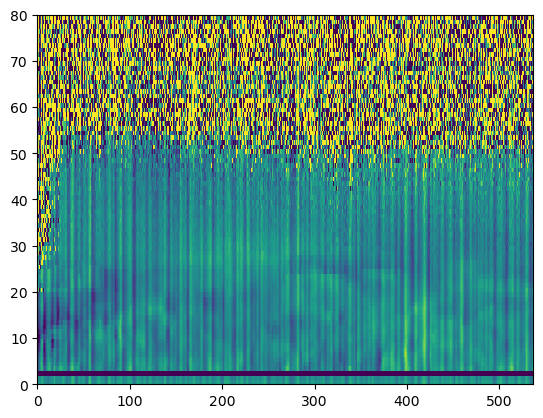

PyObject <matplotlib.collections.PolyQuadMesh object at 0x38fcfb160>

In [101]:
Ur = zeros(size(dopplervel))
Vr = zeros(size(dopplervel))
ind = findindices( Dates.value.(stare_dt[st:en]), Dates.value.(UV["time"]))
for ih in 1:ntop # loop of desperation to broadcast to consistent size
    Ur[:,ih] .= indavg( UV[:ur][:,ih], ind )
    Vr[:,ih] .= indavg( UV[:vr][:,ih], ind )
end
  
w = wtrue.(dopplervel.-heave, Ur, Vr, pitch*pi/180, roll*pi/180)
pcolor(pd(dopplervel.-heave), vmin=-2, vmax=2)

In [ ]:

(nt, nz) = size(w)
z1 = 7
ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(nt, nz, z1) # might do outside the loop
zm, dr2, dz2, D2 = displacements( ci1,ci2, Ur*timestep,Vr*timestep,
                                  pitch*pi/180,roll*pi/180, w; timestep=timestep )
rho = rhopair.(dr2, dz2) # approx r^2/3
dz2

In [ ]:
# w = St[:dopplervel] # 3202, 150 h
#=
KeySet for a Dict{Symbol, Array{Union{Missing, Float32}}} with 9 entries. Keys:
  :time
  :dopplervel
  :roll
  :beta
  :elevangle
  :azimuth
  :height
  :intensity
  :pitch
# A stare time interval goes from 5:15 to 14:22 (367 s), 53 seconds mean wind scan, then 15:15-24:22, etc.
# The first and last chunks are partial, split between earlier and later hourly data files.
# First cut, ignore the partial chunks.
=#


In [ ]:
for ih in 1:ntop # loop of desperation to broadcast to consistent size
    Ur[:,ih] .= itp_Ur.(stare_dt[st:en], ih)
    Vr[:,ih] .= itp_Vr.(stare_dt[st:en], ih)
  end
  
  w = wtrue.(dopplervel .+ heave, Ur, Vr, pitch, roll)

  (nt, nz) = size(dopplervel)
  ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(nt, nz) # might do outside the loop
  zm, dr2, dz2, D2 = displacements( ci1,ci2, Ur*dt,Vr*dt, pitch,roll, w; timestep=timestep)
  rho = rhopair(dr2, dz2) # approx r^2/3
  plot(rho, D2)
end


# w = St[:dopplervel] # 3202, 150 h
#=
KeySet for a Dict{Symbol, Array{Union{Missing, Float32}}} with 9 entries. Keys:
  :time
  :dopplervel
  :roll
  :beta
  :elevangle
  :azimuth
  :height
  :intensity
  :pitch
# A stare time interval goes from 5:15 to 14:22 (367 s), 53 seconds mean wind scan, then 15:15-24:22, etc.
# The first and last chunks are partial, split between earlier and later hourly data files.
# First cut, ignore the partial chunks.
=#


In [59]:
using Statistics


LoadError: MethodError: no method matching Float64(::DateTime)

[0mClosest candidates are:
[0m  Float64([91m::Int8[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mfloat.jl:159[24m[39m
[0m  Float64([91m::Bool[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mfloat.jl:165[24m[39m
[0m  Float64([91m::Int16[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mfloat.jl:159[24m[39m
[0m  ...


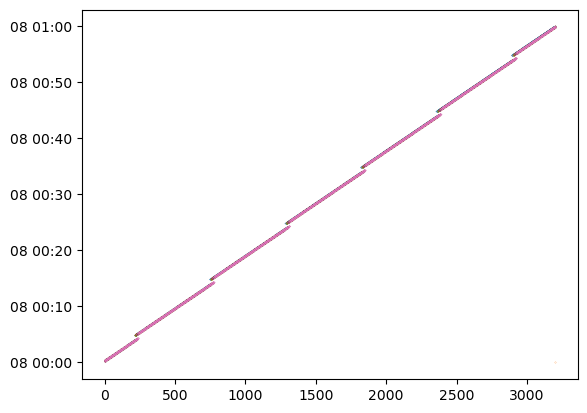

7-element Vector{DateTime}:
 2024-05-08T12:00:18.540
 2024-05-08T12:05:14.320
 2024-05-08T12:15:14.680
 2024-05-08T12:25:15.048
 2024-05-08T12:35:15.432
 2024-05-08T12:45:15.812
 2024-05-08T12:55:16.172

In [50]:
# load hourly lidar w stares
for dt = DateTime(2024,5,8,0):Hour(2):DateTime(2024,5,8,12)
    St, _ = read_streamlinexr_stare( dt )
    stare_dt = @. DateTime(Date(dt)) + Millisecond(floor(Int64, St[:time] * 3_600_000 )) # 3202
    #break into chunks
    pickets = findall( t -> t>Second(30), diff(stare_dt) )
    st = [1; pickets.+1]
    en = [pickets; length(stare_dt)]
    [stare_dt[st], stare_dt[en]]
    plot(stare_dt.-Hour.(stare_dt), linestyle="none", marker=".", markersize=0.3)
end
stare_dt[st]

In [ ]:

itp_U(dt) = timeinterp( U)

# load an hourly lidar hpl file
Lid = read_streamlinexr_stare( dt ) # Dict
time = Lid[:time]
nt = length(time)
w = Lid[:w]

# zm, dr2, dz2, D2 = displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate )